In [75]:
import cv2
import numpy as np
import operator
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
from tensorflow.keras.models import load_model
%matplotlib inline

def dist_betn(pt1,pt2):
    xd = (pt2[0] - pt1[0])**2
    yd = (pt2[1] - pt1[1])**2
    return np.sqrt(xd + yd)

def ext_cell_coor(square):
    cells_coor = np.zeros((81,4),dtype= float)
    grid_side = square.shape[:1]
    cell_side = grid_side[0]/9
    k=0
    for i in range(9):
        for j in range(9):
            x1, y1 = (i * cell_side, j * cell_side) 
            x2, y2 = ((i + 1) * cell_side, (j + 1) * cell_side)
            cells_coor[k, :]=[x1, y1, x2, y2]
            k=k+1
    return cells_coor
    
def extract_clean_digit(img,coor):
    x1,y1,x2,y2 = coor
    cell = img[int(x1):int(x2),int(y1):int(y2)]
    dig = cv2.resize(cell,(45,45),interpolation = cv2.INTER_CUBIC)
    digit=dig/np.max(dig)
    return digit

def verify_possile_value(x, y, n, grid):
    for i in range(0, 9):
        if grid[x, i]==n:
            return False
        
    for i in range(0, 9):
        if grid[i, y]==n:
            return False
    x0=(x//3)*3
    y0=(y//3)*3
    for i in range(0, 3):
        for j in range(0, 3):
            if grid[x0+i, y0+j]==n:
                return False
            
    return True



#fill in the empty slots:
def grid_solver(grid):
    for x in range(9):
        for y in range(9):
            if grid[x, y]==0:
                for n in range(1, 10):
                    if verify_possile_value(x, y, n, grid):
                        grid[x, y]=n
                        result=grid_solver(grid)
                        
                        if result is not None:
                            return result
                        
                        grid[x, y]=0 #Backtracking
                return None               
    return grid

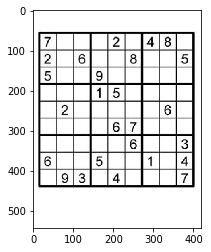

In [85]:
sudoku_img = cv2.imread('sudoku_image.jpg')
sy= int(sudoku_img.shape[0]*1.5)
sx=int(sy*(sudoku_img.shape[1]/sudoku_img.shape[0]))
sudoku_img =cv2.resize(sudoku_img,(sx,sy), interpolation = cv2.INTER_AREA)
gray = cv2.cvtColor(sudoku_img,cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(5,5),0)
thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

plt.imshow(sudoku_img)

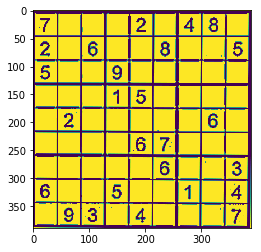

In [86]:
cont,heir = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(cont, key=cv2.contourArea,reverse=True)
biggest = contours[1]
bottom_right,_ = max(enumerate([pt[0][0] + pt[0][1] for pt in biggest]), key=operator.itemgetter(1))
top_left,_ = min(enumerate([pt[0][0] + pt[0][1] for pt in biggest]), key=operator.itemgetter(1))
top_right,_ = max(enumerate([pt[0][0] - pt[0][1] for pt in biggest]), key=operator.itemgetter(1))
bottom_left,_ = min(enumerate([pt[0][0] - pt[0][1] for pt in biggest]), key=operator.itemgetter(1))
corners = biggest[top_left][0], biggest[top_right][0], biggest[bottom_right][0], biggest[bottom_left][0]
top_left, top_right, bottom_right, bottom_left = corners

src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

side = max([dist_betn(top_left, top_right),
           dist_betn(top_right, bottom_right),
            dist_betn(bottom_right,bottom_left),
            dist_betn(bottom_left,top_left)])

dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')
m = cv2.getPerspectiveTransform(src, dst)

cropped=cv2.warpPerspective(thresh, m, (int(side), int(side)))

ret, im = cv2.invert(m)

plt.imshow(cropped)

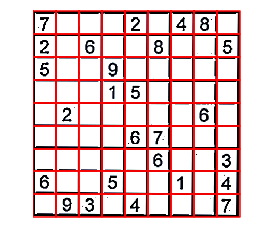

In [87]:
cells_coor=ext_cell_coor(cropped)
plt.imshow(cropped, cmap='bone')  
for i in range(0, np.shape(cells_coor)[0]):
    x1, y1, x2, y2=cells_coor[i, :]
    x=[x1, x2, x2, x1, x1]
    y=[y1, y1, y2, y2, y1]
    plt.plot(x, y, 'r')
plt.axis('off')
plt.show()

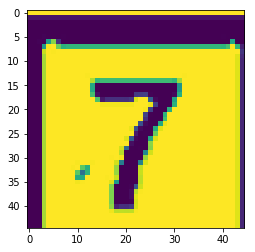

In [88]:
cells_coor=ext_cell_coor(cropped)
total_digit = np.zeros((81,45,45),dtype = float)
for i in range(cells_coor.shape[0]):
    digit = extract_clean_digit(cropped,cells_coor[i,:])
    total_digit[i,:,:] = digit

plt.imshow(total_digit[0])
plt.show()

In [89]:
hist1 = load_model('newmodel.h5',compile=False);
p = np.zeros((81))

for i in range(81):
    p[i] = (hist1.predict(total_digit[i].reshape(1,45,45,1))).argmax(1)
p = p.reshape(9,9)  
q=np.copy(p)
p

array([[7., 0., 0., 0., 4., 0., 8., 6., 0.],
       [4., 0., 5., 0., 0., 6., 0., 0., 1.],
       [1., 0., 0., 2., 0., 0., 0., 0., 0.],
       [0., 0., 0., 9., 1., 0., 0., 0., 0.],
       [0., 4., 0., 0., 0., 0., 0., 5., 0.],
       [0., 0., 0., 0., 5., 7., 0., 0., 0.],
       [0., 0., 0., 0., 0., 5., 0., 0., 3.],
       [5., 0., 0., 1., 0., 0., 9., 0., 8.],
       [0., 2., 3., 0., 8., 0., 0., 0., 7.]])

In [90]:
solved =grid_solver(p)
solved

array([[7., 3., 2., 5., 4., 1., 8., 6., 9.],
       [4., 8., 5., 3., 9., 6., 2., 7., 1.],
       [1., 6., 9., 2., 7., 8., 4., 3., 5.],
       [3., 5., 6., 9., 1., 4., 7., 8., 2.],
       [9., 4., 7., 8., 3., 2., 1., 5., 6.],
       [2., 1., 8., 6., 5., 7., 3., 9., 4.],
       [8., 9., 1., 7., 2., 5., 6., 4., 3.],
       [5., 7., 4., 1., 6., 3., 9., 2., 8.],
       [6., 2., 3., 4., 8., 9., 5., 1., 7.]])

In [91]:
cells_coor =cells_coor.reshape(9,9,4)

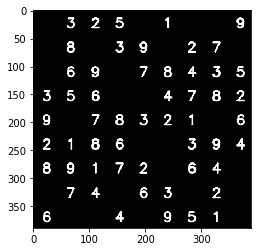

In [92]:
vir_image=np.zeros((cropped.shape[0],cropped.shape[1],3), dtype=np.uint8)
for i in range(9):
    for j in range(9):
        if q[j,i]==0:
            num = int(solved[j,i])
            coor = cells_coor[i,j]
            x_c = int((coor[0]+coor[2])/2)
            y_c = int((coor[1]+coor[3])/2)
            cv2.putText(vir_image,str(num),(x_c-5,y_c+10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2,cv2.LINE_AA)   

plt.imshow(vir_image)

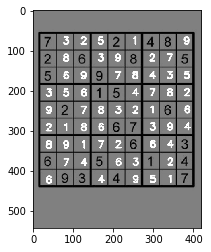

In [93]:
gray1 = cv2.cvtColor(vir_image,cv2.COLOR_BGR2GRAY)
image12=cv2.warpPerspective(gray1, im, (sx,sy), cv2.WARP_INVERSE_MAP)
image21=cv2.cvtColor(image12,cv2.COLOR_GRAY2BGR)
image = cv2.addWeighted(image21,1,sudoku_img,0.5,0)
plt.imshow(image)